In [1]:
import os
import warnings

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import xarray as xr
import yaml
from matplotlib.offsetbox import AnchoredText
from xhistogram.xarray import histogram as xhist

warnings.filterwarnings("ignore")

In [2]:
inpath = "/gxfs_work/geomar/smomw452/GLORYS12/Data/"

MLD = xr.open_mfdataset(inpath + "MLD_*.nc", combine="by_coords").somxl010

mesh_mask = xr.open_dataset(inpath + "mesh_masks/combined_mesh_mask.nc")

z = mesh_mask.e3t_0
t_mask = mesh_mask.tmask

# bathymetry (Depth level) at every grid point
bathymetry = (z * t_mask).isel(t=0).sum(dim="z")

# turn zeros into nans, easier to see where continents are
bath_total_nans = bathymetry.where(bathymetry != 0)
land_mask = mesh_mask.tmask.where(mesh_mask.tmask != 0).isel(t=0, z=0)


def select_data(data):
    north_sel = data.isel(y=slice(300, None), x=slice(300, None))
    return north_sel


MLD = select_data(MLD)

mesh_mask = select_data(mesh_mask)
bathymetry = select_data(bathymetry)
land_mask = select_data(land_mask)


# get grid cell sizes
dx = mesh_mask.e1t.isel(
    t=0
)  # .assign_coords({"nav_lon": S.nav_lon,"nav_lat": S.nav_lat})

dy = mesh_mask.e2t.isel(
    t=0
)  # .assign_coords({"nav_lon": S.nav_lon,"nav_lat": S.nav_lat})
grid_cell_area = mesh_mask.e1t.isel(t=0) * mesh_mask.e2t.isel(t=0)

total_area = grid_cell_area.sum(["y", "x"])

bathymetry = bathymetry.assign_coords(
    {"nav_lon": mesh_mask.nav_lon, "nav_lat": mesh_mask.nav_lat}
)

mask_lofoten_bathy = xr.where(bathymetry > 3000, 1, np.nan).where(
    (bathymetry.nav_lat > 68)
    & (bathymetry.nav_lat < 72.5)
    & (bathymetry.nav_lon > -5)
    & (bathymetry.nav_lon < 15),
    drop=False,
)

mask_grnl_sea_bathy = xr.where(bathymetry > 3000, 1, np.nan).where(
    (bathymetry.nav_lat > 72)
    & (bathymetry.nav_lat < 78.5)
    & (bathymetry.nav_lon > -12.5)
    & (bathymetry.nav_lon < 6.5),
    drop=False,
)

In [18]:
ds_LOFOTEN = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/particles/LOFOTEN_particles_source.nc"
)
ds_LOFOTEN = ds_LOFOTEN.rename({"longitude": "lon", "latitude": "lat"})
ds_GREENLAND = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/CLEANUP_notebooks/particles/GSea_particles_source_1995_2020.nc"
)
ds_GREENLAND = ds_GREENLAND.assign_coords(
    start_time=("start_time", ds_GREENLAND.start_time.values)
)


def compute_probability_perc(traj_line_not_all):
    # create a 2D histogram of the latitude and longitude
    heat_map_time_non = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    # count unique trajectories in each bin
    heat_map_time_unique_non = (heat_map_time_non > 0).sum(dim="trajectory")

    # calculate the percentage of trajectories in each bin
    heat_map_percentage_non = (
        heat_map_time_unique_non / ds_GREENLAND.trajectory.size
    ) * 100  # get percentage
    heat_map_percentage_non_cp = heat_map_percentage_non.compute()

    return heat_map_percentage_non_cp


def calculate_heatmap(ds):
    heat_map = xhist(
        ds.lat, ds.lon, bins=[lat_bins, lon_bins], dim=["trajectory"], bin_dim_suffix=""
    )
    heat_map = heat_map.where(heat_map > 0)
    return heat_map


def calc_min_max(ds):
    lon_min = float(ds.lon.min().values)
    lon_max = float(ds.lon.max().values)
    lat_min = float(ds.lat.min().values)
    lat_max = float(ds.lat.max().values)
    res = {
        "lon_min": lon_min,
        "lon_max": lon_max,
        "lat_min": lat_min,
        "lat_max": lat_max,
    }
    return res


def compute_probability_weighted(traj_line_not_all):
    # 2D histogram over lat/lon; sum over 'obs' (all recorded positions)
    heat_map_counts = xhist(
        traj_line_not_all.lat,
        traj_line_not_all.lon,
        bins=[lat_bins, lon_bins],
        dim=["obs"],
        bin_dim_suffix="",
    )

    # sum over trajectories to get total positions per bin
    heat_map_total = heat_map_counts.sum(dim="trajectory").compute()

    # normalize to fraction of all positions
    heat_map_prob = heat_map_total / heat_map_total.sum()

    return heat_map_prob


outdir = "/gxfs_work/geomar/smomw452/GLORYS12/schillerweiss_2025/notebooks/data/level3/"
if not os.path.exists(outdir):
    os.makedirs(outdir)
if os.path.exists(f"{outdir}/minmax.yaml"):
    with open(f"{outdir}/minmax.yaml", "r") as file:
        results = yaml.load(file, Loader=yaml.FullLoader)
else:
    results = calc_min_max(ds_LOFOTEN)
    with open(f"{outdir}/minmax.yaml", "w") as file:
        yaml.dump(results, file)

n = 0.25  # .25
lon_bins = np.arange(results["lon_min"], results["lon_max"], n)
lat_bins = np.arange(results["lat_min"], results["lat_max"], n)


def rechunk_for_hist(var):
    return var.chunk({"trajectory": 50, "obs": -1})

In [4]:
ds_GREENLAND = ds_GREENLAND.assign_coords(
    start_time=("start_time", ds_GREENLAND.start_time.values)
)
hmap_GSea = compute_probability_perc(ds_GREENLAND)
hmap_weighted_Gsea = compute_probability_weighted(ds_GREENLAND)

In [5]:
lon, lat = hmap_GSea.lon, hmap_GSea.lat

In [6]:
contour_interval = 700

contour_levels = np.arange(
    np.floor(bathymetry.min() / contour_interval) * contour_interval,
    np.ceil(bathymetry.max() / contour_interval) * contour_interval,
    contour_interval,
)

In [7]:
plt.rcParams.update({"font.size": 13})

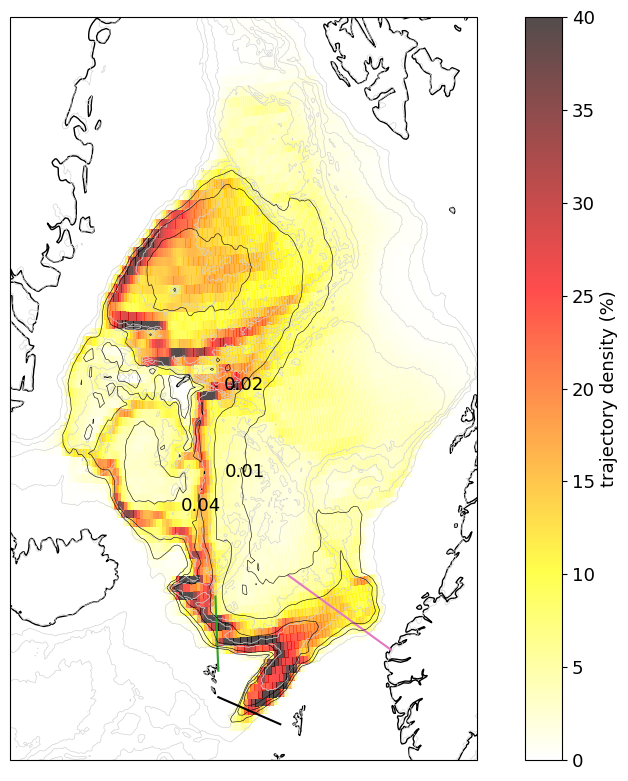

In [ ]:
# Projection
proj = ccrs.LambertConformal(central_longitude=-10, central_latitude=70)

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": proj})

# Map extent
ax.set_extent([-20, 10, 59, 80], crs=ccrs.PlateCarree())

# Heatmap of Greenland Sea particles
m1 = ax.pcolormesh(
    lon,
    lat,
    hmap_GSea,
    cmap="hot_r",
    vmin=0,
    vmax=40,
    alpha=0.7,
    transform=ccrs.PlateCarree(),
)

# Coastlines and bathymetry
ax.coastlines()
ax.contour(
    mesh_mask.nav_lon,
    mesh_mask.nav_lat,
    bathymetry,
    levels=contour_levels,
    colors="lightgray",
    linewidths=0.5,
    alpha=1,
    transform=ccrs.PlateCarree(),
)

# Sections
ax.plot(
    [5.5, -1],
    [62.24, 65.0],
    color="tab:pink",
    label="Svinoy section",
    transform=ccrs.PlateCarree(),
)
ax.plot(
    [-6.43, -6.43],
    [62.15, 64.5],
    color="tab:green",
    label="N section",
    transform=ccrs.PlateCarree(),
)
ax.plot([-6.5, -2.5], [61.3, 60.3], color="k", transform=ccrs.PlateCarree())

# Overlay: weighted traffic intensity
cs = ax.contour(
    hmap_weighted_Gsea.lon,
    hmap_weighted_Gsea.lat,
    hmap_weighted_Gsea * 100,
    levels=[0.01, 0.02, 0.04],
    colors="k",
    linewidths=0.4,
    transform=ccrs.PlateCarree(),
)

# Add labels along contours
for i, level in enumerate(cs.levels):
    path = cs.collections[i].get_paths()[0]
    vertices = path.vertices
    idx = len(vertices) // 4
    lon_label, lat_label = vertices[idx]
    ax.text(
        lon_label,
        lat_label,
        f"{level:.2f}",
        transform=ccrs.PlateCarree(),
        fontsize=13,
        color="k",
        ha="center",
        va="center",
    )

# Colorbar
fig.colorbar(m1, ax=ax, orientation="vertical").set_label("trajectory density (%)")

# Title
ax.set_title("")

plt.tight_layout()
# plt.savefig('S1',dpi=300, bbox_inches='tight')

plt.show()

## Figure S2

In [9]:
ds = xr.open_dataset(
    "/gxfs_work/geomar/smomw452/GLORYS12/GLORYS_data_download_scripts/hovmollers_Lofoten_GSea.nc"
)

S_hovmoller_lofoten = ds["S_lofoten"]
T_hovmoller_lofoten = ds["T_lofoten"]
S_hovmoller_grnl_sea = ds["S_grnl_sea"]
T_hovmoller_grnl_sea = ds["T_grnl_sea"]

In [10]:
def calculate_slope_intercept(x1, y1, x2, y2):
    """compute the slope (m) and y-intercept (b) of a line."""
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b


m, b = calculate_slope_intercept(-5, 70.5, 2, 68.2)
m1, b1 = calculate_slope_intercept(-5, 71, 5, 72.5)

m_gsea, b_gsea = calculate_slope_intercept(-1, 72.1, 7, 73.5)
ds_window1 = (mask_lofoten_bathy.nav_lat >= mask_lofoten_bathy.nav_lon * m + b).astype(
    int
)
ds_window2 = (
    mask_lofoten_bathy.nav_lat <= mask_lofoten_bathy.nav_lon * m1 + b1
).astype(int)

# mask the basins

mask_lofoten = (ds_window1 * ds_window2 * mask_lofoten_bathy).where(
    ds_window1 * ds_window2 * mask_lofoten_bathy != 0
)

ds_window_gsea = (
    mask_grnl_sea_bathy.nav_lat >= mask_grnl_sea_bathy.nav_lon * m_gsea + b_gsea
).astype(int)
mask_grnl_sea = (ds_window_gsea * mask_grnl_sea_bathy).where(
    ds_window_gsea * mask_grnl_sea_bathy != 0
)

In [11]:
def weighted_time_series(masked_variable):
    m = masked_variable[0, :, :] * 0 + 1  # 2d mask of ones and nans
    w = grid_cell_area / total_area
    w_mask = m * w
    w = w_mask / np.nansum(w_mask)
    new_weights = (masked_variable * w).sum(("y", "x"))
    # print(new_weights.shape)
    new_weights = new_weights
    return new_weights


MLD_hovmoller_lofoten = weighted_time_series(MLD * mask_lofoten).compute()
MLD_hovmoller_grnl_sea = weighted_time_series(MLD * mask_grnl_sea).compute()

In [12]:
# Custom colormap: darker blues, white at center, deep reds
colors_temp = [
    "#081d58",  # very dark navy
    "#08306b",  # dark blue
    "#08519c",  # deep blue
    "#2171b5",  # medium blue
    "#ffffff",  # white at -0.8 °C
    "#fb6a4a",  # red
    "#cb181d",  # dark red
    "#67000d",  # very dark red
]
cmap_temp = mcolors.LinearSegmentedColormap.from_list("cmap_temp", colors_temp)

# normalization: center white at -0.8 °C
norm_temp = mcolors.TwoSlopeNorm(vmin=-1.8, vcenter=-0.9, vmax=0.8)
time = S_hovmoller_grnl_sea.time_counter.values
depth = (
    -S_hovmoller_grnl_sea.deptht.values
)  # make negative for depth (further down is negative)
temp = T_hovmoller_grnl_sea.T.values

# discrete contour levels (every 0.1 °C)
levels = np.arange(-1.8, 0.81, 0.1)

In [13]:
plt.rcParams.update({"font.size": 16})

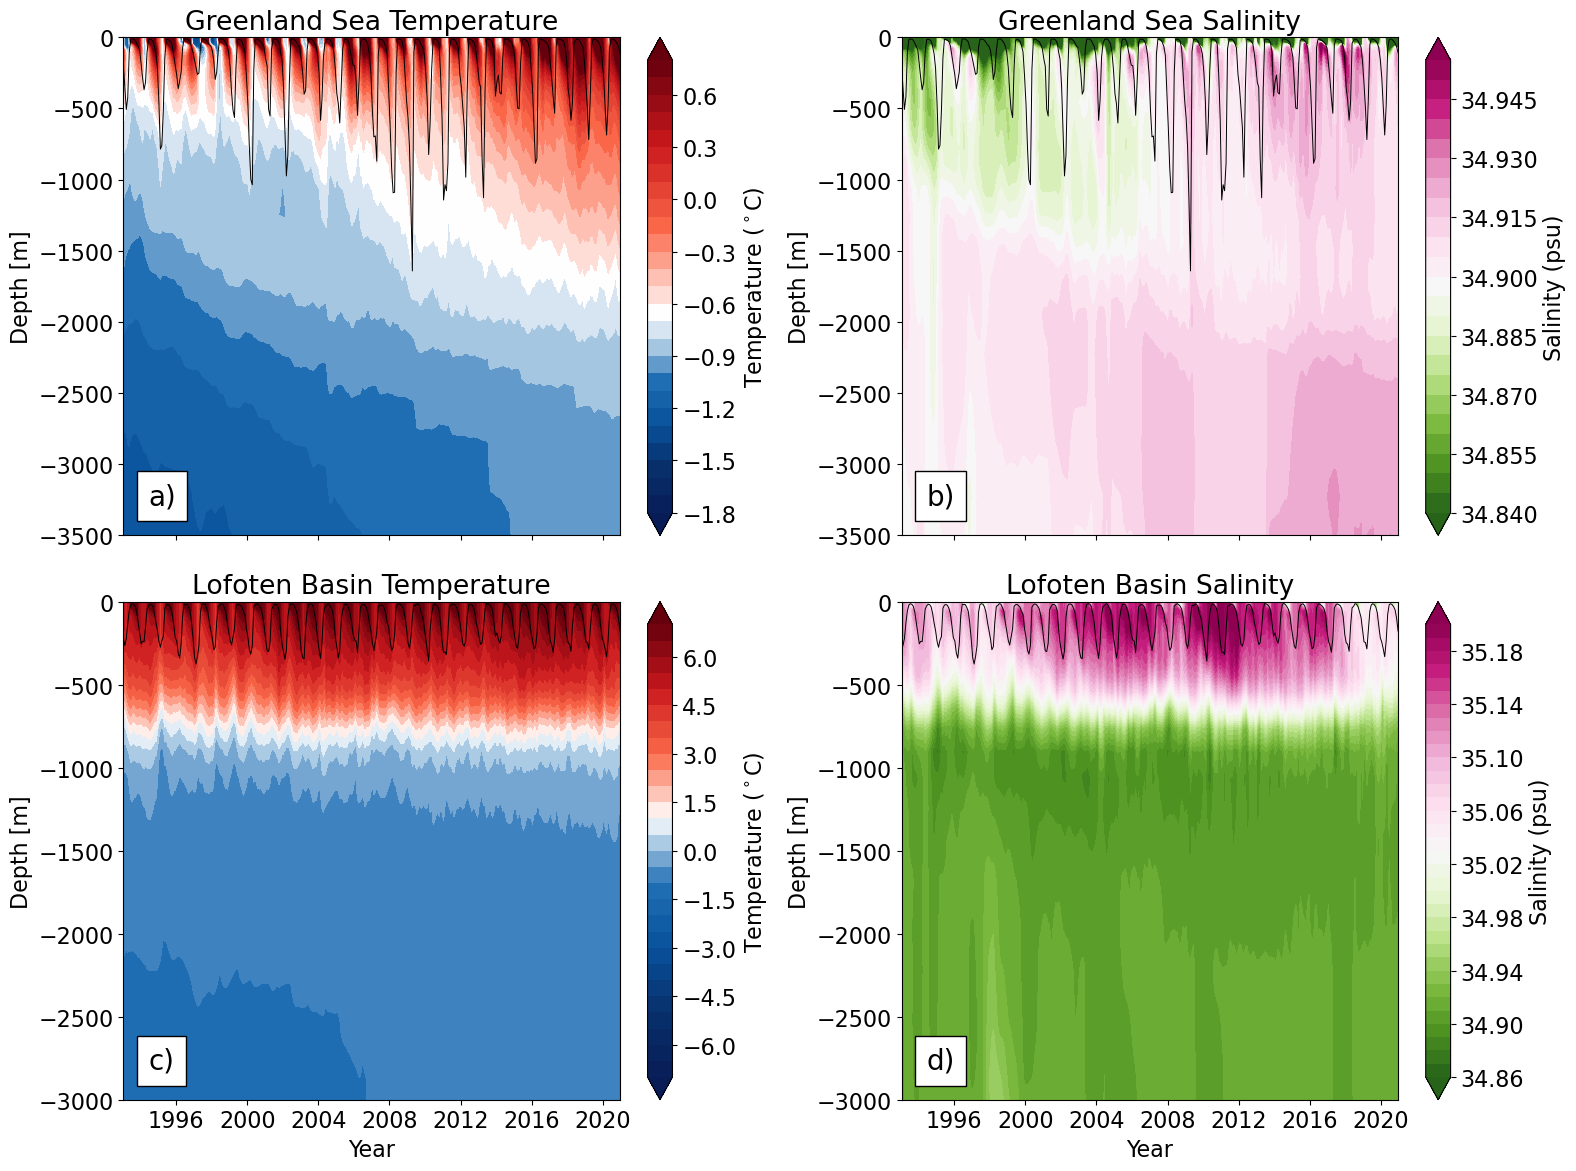

In [14]:
# -------------------
# Greenland Sea Temperature
# -------------------
time_grnl = S_hovmoller_grnl_sea.time_counter.values
depth_grnl = -S_hovmoller_grnl_sea.deptht.values
temp_grnl = T_hovmoller_grnl_sea.T.values


norm_grnl = mcolors.TwoSlopeNorm(vmin=-1.8, vcenter=-0.9, vmax=0.8)
levels_grnl = np.arange(-1.8, 0.81, 0.1)

# -------------------
# Lofoten Basin Temperature
# -------------------
time_lof = T_hovmoller_lofoten.time_counter.values
depth_lof = -T_hovmoller_lofoten.deptht.values
temp_lof = T_hovmoller_lofoten.T.values


cmap_temp = mcolors.LinearSegmentedColormap.from_list("cmap_temp", colors_temp)
norm_lof = mcolors.TwoSlopeNorm(vmin=-7, vcenter=0, vmax=7)
levels_lof = np.arange(-7, 7.1, 0.5)

# -------------------
# Greenland Sea Salinity
# -------------------
sali_grnl = S_hovmoller_grnl_sea.values
levels_sali_grnl = np.arange(34.84, 34.96, 0.005)

# -------------------
# Lofoten Basin Salinity
# -------------------
sali_lof = S_hovmoller_lofoten.values
levels_sali_lof = np.arange(34.86, 35.2, 0.01)


fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=True)

# Greenland sea temp plot
cf1 = axes[0, 0].contourf(
    time_grnl,
    depth_grnl,
    temp_grnl,
    levels=levels_grnl,
    cmap=cmap_temp,
    norm=norm_grnl,
    extend="both",
)
axes[0, 0].plot(time_grnl, -MLD_hovmoller_grnl_sea, "k", linewidth=0.7)
axes[0, 0].set_ylim(-3500, 0)
axes[0, 0].set_ylabel("Depth [m]")
axes[0, 0].set_title("Greenland Sea Temperature")
cbar1 = fig.colorbar(
    cf1, ax=axes[0, 0], orientation="vertical", fraction=0.05, pad=0.05
)
cbar1.set_label(r"Temperature ($^\circ$C)")
axes[0, 0].add_artist(
    AnchoredText("a)", prop=dict(size=20), frameon=True, loc="lower left")
)


# Greenland sea salinity plot
cf3 = axes[0, 1].contourf(
    time_grnl,
    depth_grnl,
    sali_grnl.T,
    levels=levels_sali_grnl,
    cmap="PiYG_r",
    extend="both",
)
axes[0, 1].plot(time_grnl, -MLD_hovmoller_grnl_sea, "k", linewidth=0.7)
axes[0, 1].set_ylim(-3500, 0)
axes[0, 1].set_ylabel("Depth [m]")
axes[0, 1].set_title("Greenland Sea Salinity")
cbar3 = fig.colorbar(
    cf3, ax=axes[0, 1], orientation="vertical", fraction=0.05, pad=0.05
)
cbar3.set_label(r"Salinity (psu)")
axes[0, 1].add_artist(
    AnchoredText("b)", prop=dict(size=20), frameon=True, loc="lower left")
)

# Lofoten Basin temp plot
cf2 = axes[1, 0].contourf(
    time_lof,
    depth_lof,
    temp_lof,
    levels=levels_lof,
    cmap=cmap_temp,
    norm=norm_lof,
    extend="both",
)
axes[1, 0].plot(time_lof, -MLD_hovmoller_lofoten, "k", linewidth=0.7)
axes[1, 0].set_ylim(-3000, 0)
axes[1, 0].set_ylabel("Depth [m]")
axes[1, 0].set_title("Lofoten Basin Temperature")
cbar2 = fig.colorbar(
    cf2, ax=axes[1, 0], orientation="vertical", fraction=0.05, pad=0.05
)
cbar2.set_label(r"Temperature ($^\circ$C)")
axes[1, 0].add_artist(
    AnchoredText("c)", prop=dict(size=20), frameon=True, loc="lower left")
)

# Lofoten Basin salinity plot
cf4 = axes[1, 1].contourf(
    time_lof,
    depth_lof,
    sali_lof.T,
    levels=levels_sali_lof,
    cmap="PiYG_r",
    extend="both",
)
axes[1, 1].plot(time_lof, -MLD_hovmoller_lofoten, "k", linewidth=0.7)
axes[1, 1].set_ylim(-3000, 0)
axes[1, 1].set_title("Lofoten Basin Salinity")
axes[1, 1].set_ylabel("Depth [m]")
cbar4 = fig.colorbar(
    cf4, ax=axes[1, 1], orientation="vertical", fraction=0.05, pad=0.05
)
cbar4.set_label(r"Salinity (psu)")
axes[1, 1].add_artist(
    AnchoredText("d)", prop=dict(size=20), frameon=True, loc="lower left")
)


for ax in axes[1, :]:
    ax.set_xlabel("Year")


plt.tight_layout()
# plt.savefig('S2',bbox_inches='tight',dpi=300)
plt.show()

## Figure S3

In [2]:
## N sections high versus low transport

N = xr.open_dataset("/gxfs_work/geomar/smomw452/GLORYS12/Data/N_section.nc")
N_sigma0 = (
    xr.apply_ufunc(
        sw.eos80.dens0,
        N.vosaline,
        N.votemper,
        dask="parallelized",
        output_dtypes=[np.float64],
    )
    - 1000
)
N_overflow = N.where(N_sigma0 > 28)


# high trspt
input_date_2003 = "2002-09-01", "2003-07-01"
input_date_2009 = "2009-11-01", "2010-09-01"
input_date_1997 = "1997-11-01", "1998-09-01"

# low trspt
input_date_2012 = "2011-09-01", "2012-07-01"
input_date_1999 = "1999-01-01", "1999-12-01"
input_date_2014 = "2014-12-01", "2015-10-01"


# get mean fields
vel_2003 = N.u_rot_normal.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)
sal_2003 = N.vosaline.sel(time_counter=slice(*input_date_2003)).mean(dim="time_counter")
temp_2003 = N.votemper.sel(time_counter=slice(*input_date_2003)).mean(
    dim="time_counter"
)
sigma_2003 = N_sigma0.sel(time_counter=slice(*input_date_2003)).mean(dim="time_counter")

vel_2009 = N.u_rot_normal.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)
sal_2009 = N.vosaline.sel(time_counter=slice(*input_date_2009)).mean(dim="time_counter")
temp_2009 = N.votemper.sel(time_counter=slice(*input_date_2009)).mean(
    dim="time_counter"
)
sigma_2009 = N_sigma0.sel(time_counter=slice(*input_date_2009)).mean(dim="time_counter")

vel_1997 = N.u_rot_normal.sel(time_counter=slice(*input_date_1997)).mean(
    dim="time_counter"
)
sal_1997 = N.vosaline.sel(time_counter=slice(*input_date_1997)).mean(dim="time_counter")
temp_1997 = N.votemper.sel(time_counter=slice(*input_date_1997)).mean(
    dim="time_counter"
)


vel_2012 = N.u_rot_normal.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)
sal_2012 = N.vosaline.sel(time_counter=slice(*input_date_2012)).mean(dim="time_counter")
temp_2012 = N.votemper.sel(time_counter=slice(*input_date_2012)).mean(
    dim="time_counter"
)
sigma_2012 = N_sigma0.sel(time_counter=slice(*input_date_2012)).mean(dim="time_counter")


def high_trspt(data):
    slices_high_trspt = [
        data.sel(time_counter=slice(*input_date_1997)),
        data.sel(time_counter=slice(*input_date_2003)),
        data.sel(time_counter=slice(*input_date_2009)),
    ]
    return slices_high_trspt


def low_trspt(data):
    slices_low_trspt = [
        data.sel(time_counter=slice(*input_date_2012)),
        data.sel(time_counter=slice(*input_date_1999)),
        data.sel(time_counter=slice(*input_date_2014)),
    ]
    return slices_low_trspt


high_trspt_N = xr.concat(high_trspt(N), dim="time_counter").mean(dim="time_counter")

high_trspt_sigma_N = xr.concat(high_trspt(N_sigma0), dim="time_counter").mean(
    dim="time_counter"
)

low_trspt_N = xr.concat(low_trspt(N), dim="time_counter").mean(dim="time_counter")
low_trspt_sigma_N = xr.concat(low_trspt(N_sigma0), dim="time_counter").mean(
    dim="time_counter"
)

# Difference
vel_diff_N = high_trspt_N.u_rot_normal - low_trspt_N.u_rot_normal
sal_diff_N = high_trspt_N.vosaline - low_trspt_N.vosaline
temp_diff_N = high_trspt_N.votemper - low_trspt_N.votemper


cmap_vel = plt.get_cmap("bwr")
cmap_vel.set_bad(color="gray")

cmap_sal = plt.get_cmap("PuOr_r")
cmap_sal.set_bad(color="gray")


cmap_temp = plt.get_cmap("RdBu_r")
cmap_temp.set_bad(color="gray")

In [3]:
plt.rcParams.update({"font.size": 16})

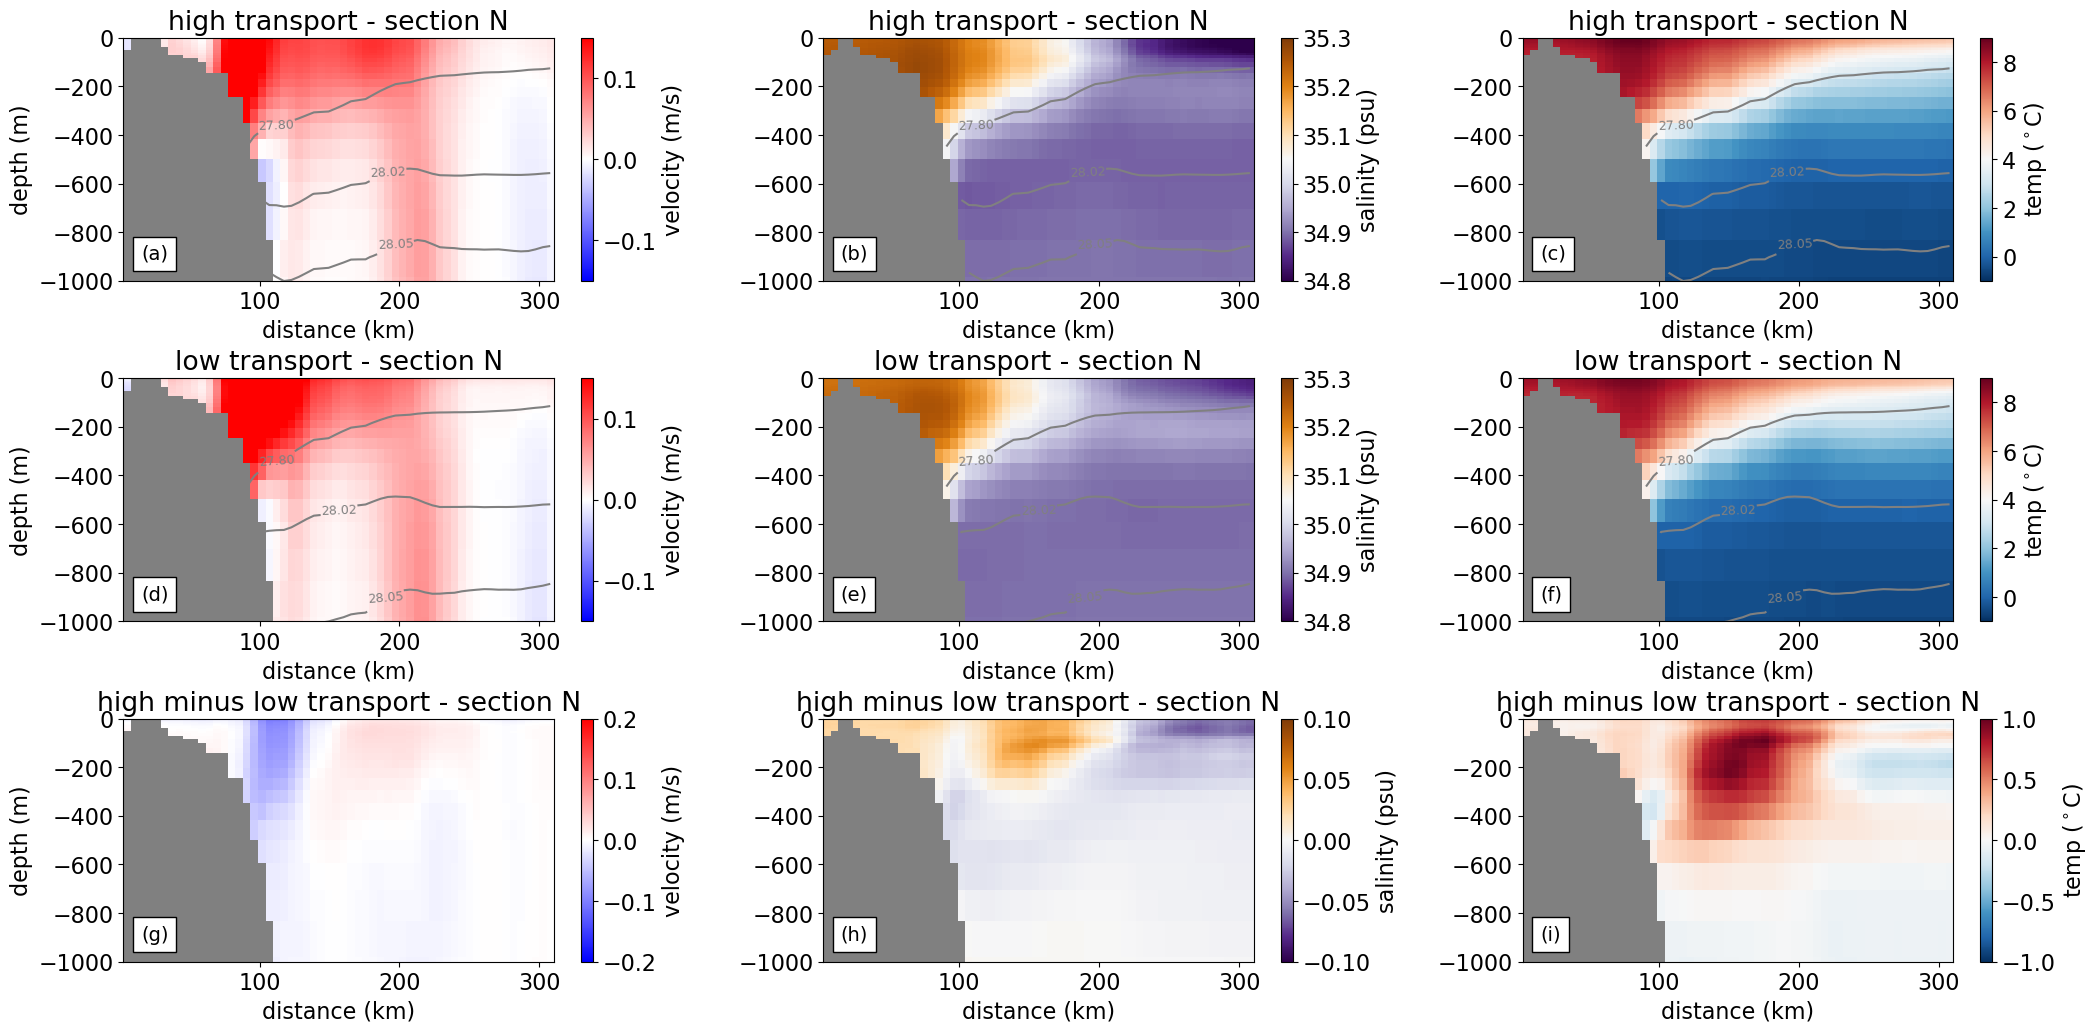

In [4]:
# === Figure layout ===
fig = plt.figure(figsize=(25, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[2.5, 2.5, 2.5], hspace=0.4, wspace=0.3)

# Panel labels
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
label_idx = 0

# === 3x3 section plots ===
for row, (vel, sal, temp, sigma, label, diff_flag) in enumerate(
    [
        (
            high_trspt_N.u_rot_normal,
            high_trspt_N.vosaline,
            high_trspt_N.votemper,
            high_trspt_sigma_N,
            "high transport - section N",
            False,
        ),
        (
            low_trspt_N.u_rot_normal,
            low_trspt_N.vosaline,
            low_trspt_N.votemper,
            low_trspt_sigma_N,
            "low transport - section N",
            False,
        ),
        (
            vel_diff_N,
            sal_diff_N,
            temp_diff_N,
            None,
            "high minus low transport - section N",
            True,
        ),
    ]
):
    for col, (data, cmap, vmin, vmax, varname) in enumerate(
        [
            (
                vel,
                cmap_vel,
                -0.2 if diff_flag else -0.15,
                0.2 if diff_flag else 0.15,
                "velocity (m/s)",
            ),
            (
                sal,
                cmap_sal,
                -0.1 if diff_flag else 34.8,
                0.1 if diff_flag else 35.3,
                "salinity (psu)",
            ),
            (
                temp,
                cmap_temp,
                -1.0 if diff_flag else -1,
                1.0 if diff_flag else 9,
                r"temp ($^\circ$C)",
            ),
        ]
    ):
        ax = fig.add_subplot(gs[row, col])
        pc = ax.pcolormesh(N.c / 1e3, -N.z, data, cmap=cmap, vmin=vmin, vmax=vmax)

        # Add density contours for non-difference plots
        if not diff_flag and sigma is not None:
            CS = ax.contour(
                N.c / 1e3,
                -N.z,
                sigma,
                [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
                colors="gray",
            )
            ax.clabel(CS, inline=True, fontsize=9)

        ax.set_xlabel("distance (km)")
        if col == 0:
            ax.set_ylabel("depth (m)")
        ax.set_ylim(-1000, 0)
        ax.set_title(label)
        fig.colorbar(pc, ax=ax).set_label(varname)

        # Add anchored label (panel letter)
        at = AnchoredText(
            labels[label_idx], loc="lower left", prop=dict(size=14), frameon=True
        )
        ax.add_artist(at)
        label_idx += 1
plt.tight_layout()
# plt.savefig('S3',dpi=300,bbox_inches='tight')
plt.show()

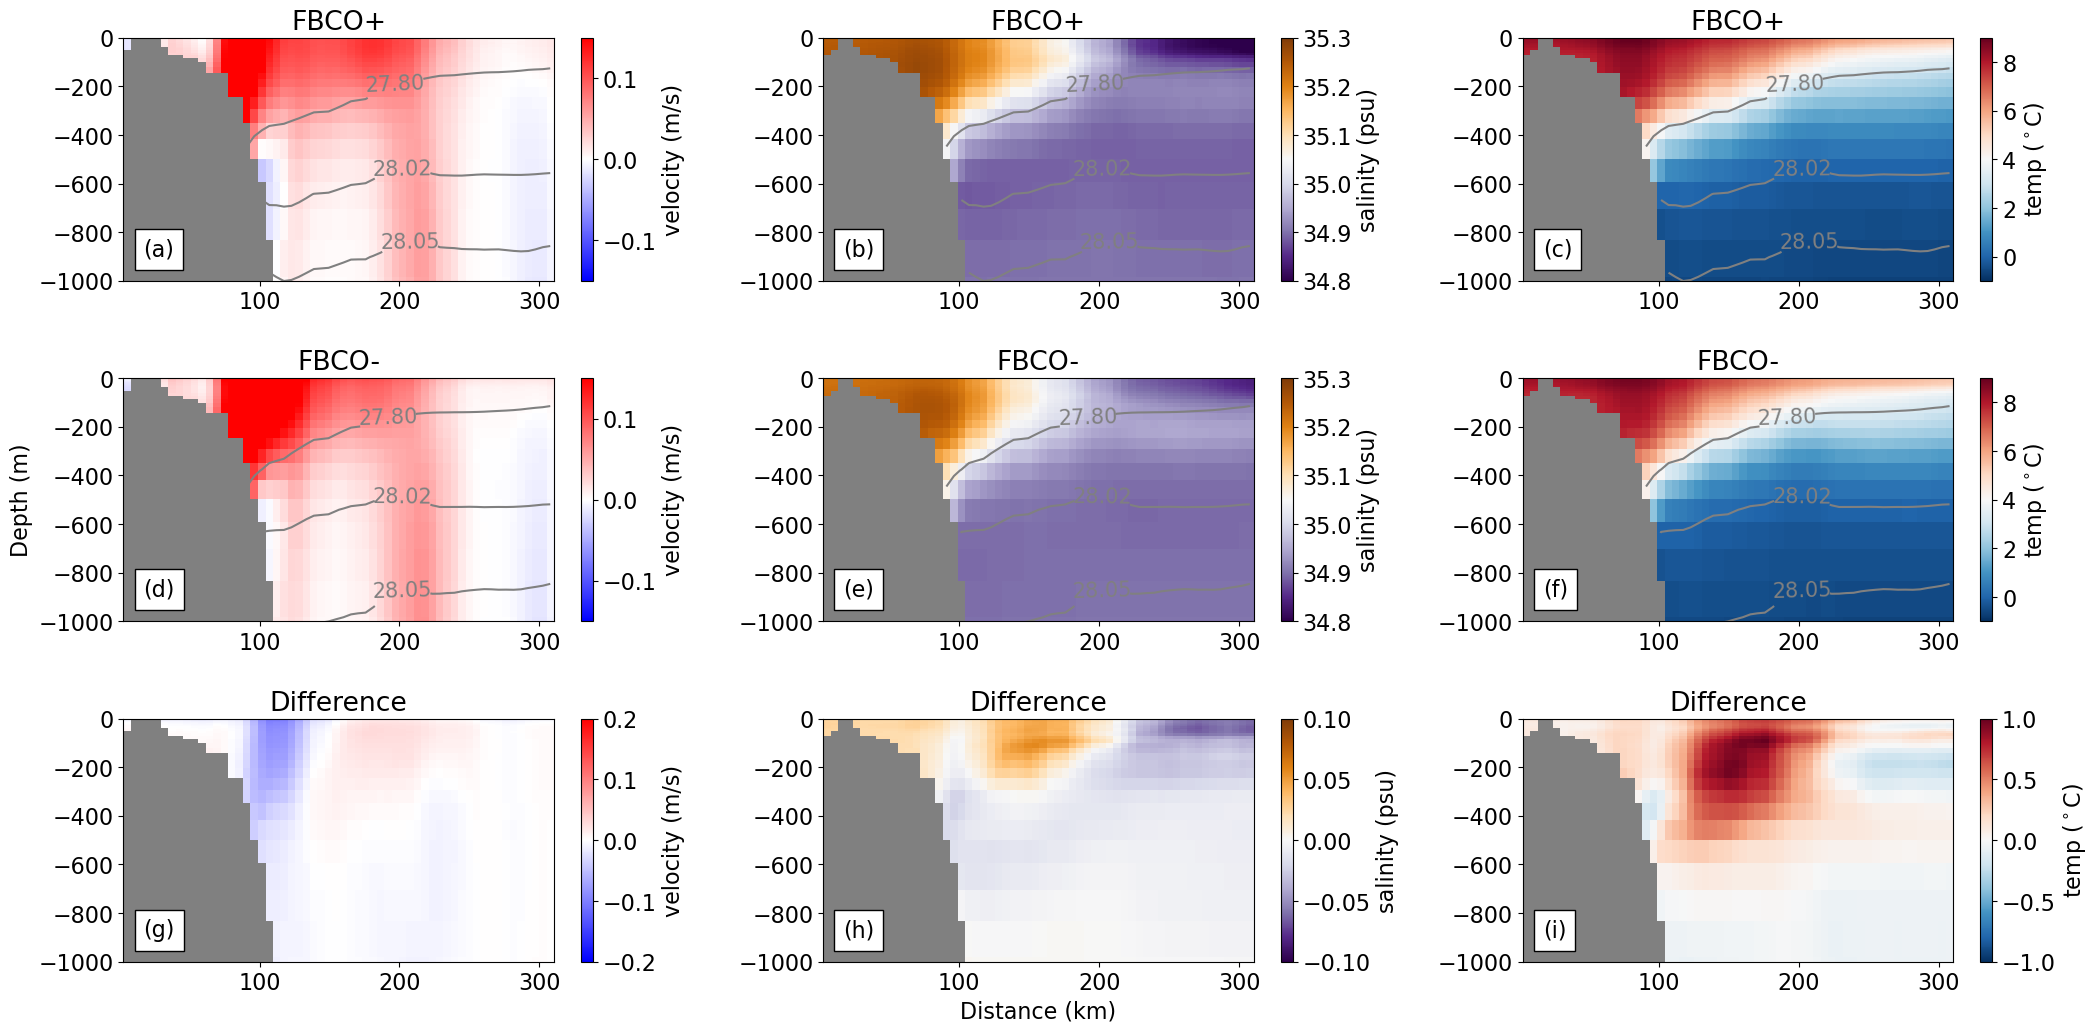

In [ ]:
# === Figure layout ===
fig = plt.figure(figsize=(25, 12))
gs = gridspec.GridSpec(3, 3, height_ratios=[2.5, 2.5, 2.5], hspace=0.4, wspace=0.3)

# Panel labels
labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)", "(i)"]
label_idx = 0

# === 3x3 section plots ===
for row, (vel, sal, temp, sigma, label, diff_flag) in enumerate(
    [
        (
            high_trspt_N.u_rot_normal,
            high_trspt_N.vosaline,
            high_trspt_N.votemper,
            high_trspt_sigma_N,
            "FBCO+",
            False,
        ),
        (
            low_trspt_N.u_rot_normal,
            low_trspt_N.vosaline,
            low_trspt_N.votemper,
            low_trspt_sigma_N,
            "FBCO-",
            False,
        ),
        (
            vel_diff_N,
            sal_diff_N,
            temp_diff_N,
            None,
            "Difference",
            True,
        ),
    ]
):
    for col, (data, cmap, vmin, vmax, varname) in enumerate(
        [
            (
                vel,
                cmap_vel,
                -0.2 if diff_flag else -0.15,
                0.2 if diff_flag else 0.15,
                "velocity (m/s)",
            ),
            (
                sal,
                cmap_sal,
                -0.1 if diff_flag else 34.8,
                0.1 if diff_flag else 35.3,
                "salinity (psu)",
            ),
            (
                temp,
                cmap_temp,
                -1.0 if diff_flag else -1,
                1.0 if diff_flag else 9,
                r"temp ($^\circ$C)",
            ),
        ]
    ):
        ax = fig.add_subplot(gs[row, col])
        pc = ax.pcolormesh(N.c / 1e3, -N.z, data, cmap=cmap, vmin=vmin, vmax=vmax)

        # Add density contours for non-difference plots
        if not diff_flag and sigma is not None:
            CS = ax.contour(
                N.c / 1e3,
                -N.z,
                sigma,
                [27.8, 28.02, 28.05, 28.06, 28.07, 28.08],
                colors="gray",
            )
            ax.clabel(CS, inline=True, fontsize=15)

        # ax.set_xlabel("distance (km)")
        # if col == 0:
        #     ax.set_ylabel("depth (m)")
        # Axis labels:
        if label_idx == 3:
            ax.set_ylabel("Depth (m)")
        else:
            ax.set_ylabel("")

        # distance label on panel (h)
        if label_idx == 7:
            ax.set_xlabel("Distance (km)")
        else:
            ax.set_xlabel("")

        ax.set_ylim(-1000, 0)
        ax.set_title(label)
        fig.colorbar(pc, ax=ax).set_label(varname)

        # Add anchored label (panel letter)
        at = AnchoredText(
            labels[label_idx], loc="lower left", prop=dict(size=16), frameon=True
        )
        ax.add_artist(at)
        label_idx += 1
plt.tight_layout()
# plt.savefig('S3',dpi=300,bbox_inches='tight')
plt.show()